In [28]:
import pandas as pd
import numpy as np

Imports the core Python libraries used throughout the analysis.
pandas is used for loading, cleaning, transforming, and aggregating tabular data, while
numpy provides numerical operations and array-based computations that support efficient data analysis.

In [29]:
sentiment = pd.read_csv("data/fear_greed_index.csv")
trades = pd.read_csv("data/historical_data.csv")

The sentiment dataset contains daily Bitcoin market sentiment classifications, while the
trades dataset contains historical trade-level information such as execution details and profit/loss.

In [30]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [31]:
trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


displays the first few rows of the sentiment dataset to verify that the data was loaded correctly and to understand its structure, column names, and sample values.

In [32]:
sentiment.columns

Index(['timestamp', 'value', 'classification', 'date'], dtype='str')

In [33]:
trades.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='str')

lists all column names in the sentiment dataset.
Inspecting column names is essential to correctly reference fields during data cleaning, timestamp conversion, and merging, and helps avoid errors caused by incorrect or assumed column names.

In [34]:
sentiment.shape
trades.shape

(211224, 16)

checks the dimensions of both datasets by displaying the number of rows and columns.

In [35]:

trades.isna().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [36]:
sentiment.isna().sum()

timestamp         0
value             0
classification    0
date              0
dtype: int64

checks for missing values in each column of the sentiment dataset.
Identifying missing values early ensures data completeness and helps determine whether any imputation or data cleaning is required before analysis.

In [37]:
sentiment.duplicated().sum()

np.int64(0)

In [38]:
trades.duplicated().sum()


np.int64(0)

checks for duplicate rows in the sentiment dataset.
Removing or confirming the absence of duplicates is important to prevent double-counting of sentiment observations during aggregation and analysis.

In [39]:

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [40]:
trades['date'] = pd.to_datetime(trades['Timestamp'], unit='ms').dt.date

converts the sentiment date column into a standardized datetime format and extracts only the calendar date.
Ensuring a consistent date format is necessary for accurate daily-level alignment and merging with the trade dataset.

In [41]:
merged = pd.merge(
    trades,
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

merges the historical trade data with the daily Fear & Greed sentiment data using the trading date as the common key.
A left join is used to retain all trade records while appending the corresponding market sentiment classification for each day, enabling sentiment-based behavioral and performance analysis.

In [42]:
merged['classification'].isna().mean()

np.float64(0.12764174525622088)

calculates the proportion of missing sentiment classifications after merging the datasets.

In [43]:
merged[['date', 'classification']].head()

,date,classification
0,2024-10-27,Greed
1,2024-10-27,Greed
2,2024-10-27,Greed
3,2024-10-27,Greed
4,2024-10-27,Greed


displays a sample of the merged dataset, showing each trade date alongside its associated market sentiment classification.
It serves as a final validation step to confirm that the merge was successful and that sentiment labels are correctly attached to the trade records.

In [44]:
merged['win'] = merged['Closed PnL'] > 0

creates a binary win/loss indicator for each trade based on its realized profit or loss.

In [45]:
merged[['Closed PnL', 'win']].head()

,Closed PnL,win
0,0.0,False
1,0.0,False
2,0.0,False
3,0.0,False
4,0.0,False


displays a sample of the profit/loss values alongside the newly created win/loss indicator.

In [46]:
daily_pnl = (
    merged
    .groupby(['Account', 'date', 'classification'])['Closed PnL']
    .sum()
    .reset_index()
)

aggregates trade-level profit and loss into daily PnL per trader, grouped by account, trading date, and market sentiment classification.
Summing Closed PnL at the daily level enables meaningful performance comparison across different sentiment regimes while reducing trade-level noise.

In [47]:
daily_pnl.head()

,Account,date,classification,Closed PnL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1.000000e+00


displays the first few rows of the aggregated daily PnL dataset.
It serves as a validation step to confirm that profit and loss values have been correctly aggregated at the trader–day level and that sentiment classifications are properly associated.

In [48]:
win_rate_by_sentiment = (
    merged
    .groupby('classification')['win']
    .mean()
    .reset_index(name='win_rate')
)

calculates the win rate for each market sentiment regime by averaging the binary win indicator.
It provides a clear comparison of how frequently trades are profitable under different sentiment conditions, enabling performance evaluation across Fear, Greed, and related regimes.

In [49]:
win_rate_by_sentiment

,classification,win_rate
0,Extreme Greed,0.490089
1,Fear,0.415146
2,Greed,0.446471
3,Neutral,0.317182


displays the computed win rates for each market sentiment category.
It allows direct comparison of trader profitability across different sentiment regimes and serves as a key input for identifying performance differences between Fear, Greed, and related market conditions.

In [50]:
trades_per_day = (
    merged
    .groupby(['date', 'classification'])
    .size()
    .reset_index(name='num_trades')
)

calculates the number of trades executed per day for each market sentiment regime.
Trade frequency is used as a behavioral metric to assess how actively traders participate under different sentiment conditions.

In [51]:
long_short = (
    merged
    .groupby(['classification', 'Side'])
    .size()
    .reset_index(name='count')
)

aggregates trades by market sentiment and trade direction (BUY or SELL).
By counting trades in each category, it enables analysis of long versus short bias under different sentiment regimes, helping identify directional behavior patterns during Fear, Greed, and related market conditions.

In [52]:
long_short

,classification,Side,count
0,Extreme Greed,BUY,3371
1,Extreme Greed,SELL,3591
2,Fear,BUY,66081
3,Fear,SELL,67790
4,Greed,BUY,15421
5,Greed,SELL,20868
6,Neutral,BUY,3505
7,Neutral,SELL,3636




Trade direction analysis shows that Fear regimes exhibit the highest trading
activity, with both BUY and SELL trades significantly higher than other
sentiment regimes. This suggests increased volatility and reactive trading
behavior during Fear periods.

During Greed and Extreme Greed regimes, SELL trades dominate BUY trades,
indicating profit-taking behavior as prices rise. Neutral sentiment periods
show relatively balanced BUY and SELL activity, reflecting indecision and
lower conviction among traders.

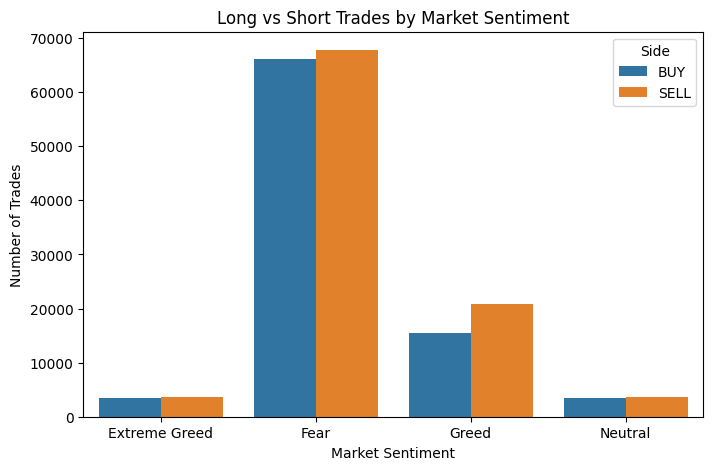

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(
    data=long_short,
    x='classification',
    y='count',
    hue='Side'
)
plt.title("Long vs Short Trades by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.show()

visualization compares the number of BUY and SELL trades across different market sentiment regimes.
The bar chart highlights directional trading bias under Fear, Greed, and related conditions, making it easier to identify periods dominated by profit-taking or aggressive positioning.

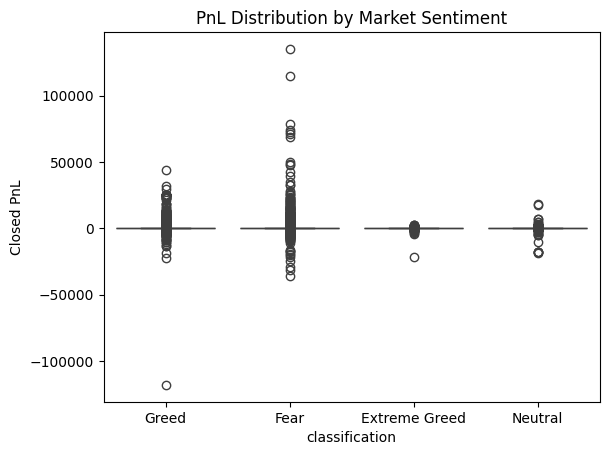

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=merged,
    x='classification',
    y='Closed PnL'
)
plt.title("PnL Distribution by Market Sentiment")
plt.show()

box plot visualizes the distribution of trade profit and loss across different market sentiment regimes.
It highlights differences in median performance, variability, and outliers between Fear, Greed, and other sentiment conditions, supporting comparative performance analysis.